# Example of classification on water dataset

### Importing dependencies and loading dataset

In [1]:
# Write your code here
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

2022-04-29 14:17:33.863533: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 14:17:33.863583: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path = "water_potability.csv"

data = pd.read_csv(path)
print(data[:][0:10])

          ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0        NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1   3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2   8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
5   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
6  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
7   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   
8        NaN  118.988579  14285.583854     7.804174  268.646941    389.375566   
9  11.180284  227.231469  25484.508491     9.077200  404.041635    563.885481   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135   

In [3]:
#Handle NaN values and split into inputs and outputs
inputs, outputs = data.iloc[:, 0:9], data.iloc[:, 9]
inputs = inputs.fillna(inputs.mean())
data = data.fillna(data.mean())

In [4]:
# Normalize
mu = inputs.mean()
sigma = inputs.std()
inputs = (inputs - mu)/sigma

print("Mean and std dev after normalization:")
print("Mean: \n", np.mean(inputs))
print("\nStd dev: \n", np.std(inputs))

inputs = inputs.to_numpy()
outputs = outputs.to_numpy()

Mean and std dev after normalization:
Mean: 
 ph                -4.674052e-16
Hardness           1.025906e-15
Solids            -4.554761e-17
Chloramines        5.205441e-16
Sulfate            1.591997e-15
Conductivity       1.756836e-16
Organic_carbon     1.735147e-17
Trihalomethanes    1.713458e-16
Turbidity          5.552471e-16
dtype: float64

Std dev: 
 ph                 0.999847
Hardness           0.999847
Solids             0.999847
Chloramines        0.999847
Sulfate            0.999847
Conductivity       0.999847
Organic_carbon     0.999847
Trihalomethanes    0.999847
Turbidity          0.999847
dtype: float64


/usr/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [5]:
from sklearn.model_selection import train_test_split

# split data with train_test_split from sklearn (provides data shuffling which is very useful)
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=3, shuffle=True)

train_size = X_train.shape[0]
test_size = X_test.shape[0]

### Classification with gaussian bayes naive classifier

In [6]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()

# fit() returns the object itself, so I can immediately call predict() on the test set
y_pred = gnb.fit(X_train, y_train).predict(X_test)

n_test = X_test.shape[0]
n_success = (y_test == y_pred).sum()
print(f"Number of correctly labeled points out of a total {n_test} points : {n_success}")
print(f"Test success rate: {n_success/n_test*100}%")

Number of correctly labeled points out of a total 819 points : 509
Test success rate: 62.14896214896215%


### Classification with fully connected network (MLP)

In [7]:
#hyperparameters
n_epochs = 20
n_steps_epoch = 500
batch_sz = train_size // n_steps_epoch


# define MLP model
class MyMLP(tf.keras.Model):

    def __init__(self):
        super().__init__()
        self.layer_in = tf.keras.layers.Dense(9, activation=tf.nn.relu)
        self.layer1 = tf.keras.layers.Dense(10, activation=tf.nn.relu)
        self.layer2 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
        self.layer3 = tf.keras.layers.Dense(4, activation=tf.nn.sigmoid)
        self.layer_out = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
    
    def call(self, inputs):
        x = self.layer_in(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        out = self.layer_out(x)
        # print(out.shape)
        return out
        
mlp = MyMLP()


mlp.compile(optimizer="Adam", loss="mse", metrics=["accuracy"], )
history = mlp.fit(X_train, y_train, 
                    epochs=n_epochs, 
                    batch_size=batch_sz, 
                    steps_per_epoch=n_steps_epoch,
                    validation_data=(X_test, y_test))
y_pred = mlp.predict(X_test)

n_test = X_test.shape[0]
y_pred = y_pred.reshape(1, y_pred.shape[0]); y_pred = y_pred[0]

2022-04-29 14:17:39.232578: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-29 14:17:39.232635: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pcspino): /proc/driver/nvidia/version does not exist
2022-04-29 14:17:39.234241: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
500/500 [==============================] - 2s 3ms/step - loss: 0.2453 - accuracy: 0.5610 - val_loss: 0.2374 - val_accuracy: 0.6068
Epoch 2/20
500/500 [==============================] - 1s 3ms/step - loss: 0.2345 - accuracy: 0.6159 - val_loss: 0.2358 - val_accuracy: 0.6068
Epoch 3/20
500/500 [==============================] - 1s 2ms/step - loss: 0.2365 - accuracy: 0.6024 - val_loss: 0.2331 - val_accuracy: 0.6081
Epoch 4/20
500/500 [==============================] - 1s 2ms/step - loss: 0.2306 - accuracy: 0.6184 - val_loss: 0.2296 - val_accuracy: 0.6276
Epoch 5/20
243/500 [=============>................] - ETA: 0s - loss: 0.2300 - accuracy: 0.6286

KeyboardInterrupt: 

26/26 [==============================] - 0s 2ms/step - loss: 0.2176 - accuracy: 0.6716

Final loss over test set: 0.2176
Final acccuracy over test set: 67.16%



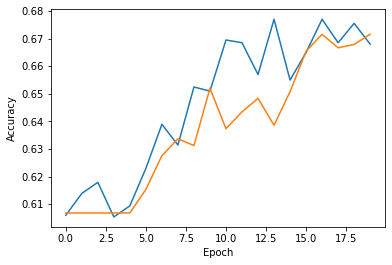

In [ ]:
loss, accuracy = mlp.evaluate(X_test, y_test)
print(f"\nFinal loss over test set: {loss:.4f}\nFinal acccuracy over test set: {accuracy*100:.2f}%\n")

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Convolutional neural network

#### Experiments with convolutional layers in tensorflow

In [ ]:
a = np.array([[[0,1,2,3,4,5,6,5,4,3,2,1,0]]], dtype='float').reshape(1,13,1)
input_sh = a.shape
print("input shape: ", input_sh)

""" First number is number of output channels, second number is kernel size
IMPORTANT: the input convolutional layer of a NN  in tensorflow expects at least a 3rd order tensor where:
 - First dimension is batch size
 - Second dimension is the dimension that is convoluted
 - Third dimension is number of input channels
 
IMPORTANT2: the input convolutional layer of a NN takes an input_shape argument that provides the input size:
input_shape=(dimension that is convoluted, number of input channels)
"""
y = tf.keras.layers.Conv1D(1, 3, input_shape=input_sh[1:])(a)
print(y)

input shape:  (1, 13, 1)
tf.Tensor(
[[[0.57033277]
  [1.3621736 ]
  [2.1540143 ]
  [2.9458551 ]
  [3.737696  ]
  [3.2537043 ]
  [4.1807117 ]
  [3.3888714 ]
  [2.5970304 ]
  [1.8051896 ]
  [1.0133488 ]]], shape=(1, 11, 1), dtype=float32)


#### Classification with convolutional NN

In [9]:
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.25, random_state=3, shuffle=True)
X_train, X_test = np.expand_dims(X_train, axis = 2), np.expand_dims(X_test, axis = 2) 

In [33]:
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

#hyperparameters
n_epochs = 50
n_steps_epoch = 100
batch_sz = train_size // n_steps_epoch
pattern_len = X_train.shape[1]

# define CNN model
class MyCNN(tf.keras.Model):

    def __init__(self):
        super().__init__()
        in_shape = (batch_sz, pattern_len, 1)
        self.conv_in = tf.keras.layers.Conv1D(20, 2, input_shape=in_shape[1:], activation=tf.nn.relu, padding="same")
        self.pool_in = tf.keras.layers.AvgPool1D(2)
        self.conv1 = tf.keras.layers.Conv1D(10, 2, activation=tf.nn.relu, padding="same")
        self.pool_1 = tf.keras.layers.AvgPool1D(2)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(10, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(1, activation=tf.nn.relu)
    
    def call(self, inputs):
        x = self.conv_in(inputs)
        x = self.pool_in(x)
        x = self.conv1(x)
        x = self.pool_1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        out = self.dense2(x)
        return out
        
cnn = MyCNN()

cnn.compile(optimizer="Adam", loss="mse", metrics=["accuracy"])
history = cnn.fit(X_train, 
                    y_train, 
                    epochs=n_epochs, 
                    batch_size=train_size//n_steps_epoch, 
                    steps_per_epoch=n_steps_epoch,
                    validation_data=(X_test, y_test))
y_pred = cnn.predict(X_test)

n_test = X_test.shape[0]
y_pred = y_pred.reshape(1, y_pred.shape[0]); y_pred = y_pred[0]

Epoch 1/50
100/100 [==============================] - 1s 6ms/step - loss: 0.2443 - accuracy: 0.6125 - val_loss: 0.2442 - val_accuracy: 0.6178
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.2326 - accuracy: 0.6184 - val_loss: 0.2419 - val_accuracy: 0.6044
Epoch 3/50
100/100 [==============================] - 1s 5ms/step - loss: 0.2315 - accuracy: 0.6306 - val_loss: 0.2411 - val_accuracy: 0.5995
Epoch 4/50
100/100 [==============================] - 0s 4ms/step - loss: 0.2303 - accuracy: 0.6159 - val_loss: 0.2389 - val_accuracy: 0.6142
Epoch 5/50
100/100 [==============================] - 1s 6ms/step - loss: 0.2291 - accuracy: 0.6306 - val_loss: 0.2415 - val_accuracy: 0.5873
Epoch 6/50
100/100 [==============================] - 1s 6ms/step - loss: 0.2268 - accuracy: 0.6331 - val_loss: 0.2466 - val_accuracy: 0.6117
Epoch 7/50
100/100 [==============================] - 1s 6ms/step - loss: 0.2286 - accuracy: 0.6285 - val_loss: 0.2377 - val_accuracy: 0.6227
Epoch 

26/26 [==============================] - 0s 2ms/step - loss: 0.2317 - accuracy: 0.6276

Final loss over test set: 0.2317
Final acccuracy over test set: 62.76%



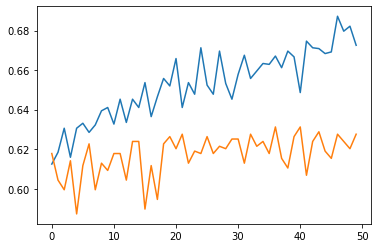

In [34]:
test_loss, test_acc = cnn.evaluate(X_test, y_test)
print(f"\nFinal loss over test set: {test_loss:.4f}\n\
Final acccuracy over test set: {test_acc*100:.2f}%\n")

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()